# Skimming large amounts of Sentinel 2 data
In this notebook, we will show how using `geolt.skim` and `geolt.summarize` can help prepare and visualize large sets of data.

In [30]:
import dask.distributed
import folium
import folium.plugins
import geopandas as gpd
import shapely.geometry
from IPython.display import HTML, display
from pystac_client import Client
import pandas as pd
import xarray 
#from geolt import skim

from odc.stac import configure_rio, stac_load


def convert_bounds(bbox, invert_y=False):
    """
    Helper method for changing bounding box representation to leaflet notation

    ``(lon1, lat1, lon2, lat2) -> ((lat1, lon1), (lat2, lon2))``
    """
    x1, y1, x2, y2 = bbox
    if invert_y:
        y1, y2 = y2, y1
    return ((y1, x1), (y2, x2))

In [2]:
cfg = {
    "sentinel-s2-l2a-cogs": {
        "assets": {
            "*": {"data_type": "uint16", "nodata": 0},
            "SCL": {"data_type": "uint8", "nodata": 0},
            "visual": {"data_type": "uint8", "nodata": 0},
        },
        "aliases": {"red": "B04", "green": "B03", "blue": "B02"},
    },
    "*": {"warnings": "ignore"},
}

## Start Dask Client

This step is optional, but it does improve load speed significantly. You
don't have to use Dask, as you can load data directly into memory of the
notebook.

In [3]:
client = dask.distributed.Client()
configure_rio(cloud_defaults=True, aws={"aws_unsigned": True}, client=client)
display(client)

2022-08-01 21:33:01,624 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/x3/gcqk_pm125n_d0fl67fn2fjw0000gn/T/dask-worker-space/worker-tpdup5gw', purging
2022-08-01 21:33:01,625 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/x3/gcqk_pm125n_d0fl67fn2fjw0000gn/T/dask-worker-space/worker-0york0u9', purging
2022-08-01 21:33:01,625 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/x3/gcqk_pm125n_d0fl67fn2fjw0000gn/T/dask-worker-space/worker-vm4i51gn', purging
2022-08-01 21:33:01,626 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/x3/gcqk_pm125n_d0fl67fn2fjw0000gn/T/dask-worker-space/worker-ebrharni', purging


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:56457,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:56481,Total threads: 2
Dashboard: http://127.0.0.1:56482/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:56463,


## Find STAC Items to Load

In [70]:
km2deg = 1.0 / 111
#x, y = (113.887, -25.843)
x, y = (-97.744, 30.266)  # Center point of a query
r = 100 * km2deg
bbox = (x - r, y - r, x + r, y + r)

catalog = Client.open("https://earth-search.aws.element84.com/v0")

query = catalog.search(
    collections=["sentinel-s2-l2a-cogs"], datetime="2022-07-01/2022-07-31", limit=100, bbox=bbox
)

items = list(query.get_items())
print(f"Found: {len(items):d} datasets")

# Convert STAC items into a GeoJSON FeatureCollection
stac_json = query.get_all_items_as_dict()

Found: 84 datasets


## Review Query Result

We'll use GeoPandas DataFrame object to make plotting easier.

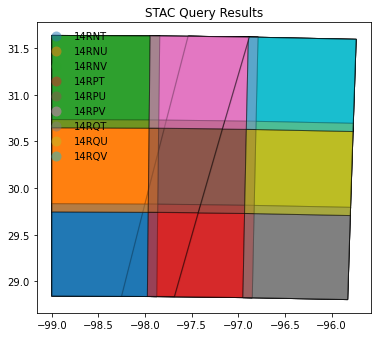

In [71]:
gdf = gpd.GeoDataFrame.from_features(stac_json, "epsg:32614")

# Compute granule id from components
gdf["granule"] = (
    gdf["sentinel:utm_zone"].apply(lambda x: f"{x:02d}")
    + gdf["sentinel:latitude_band"]
    + gdf["sentinel:grid_square"]
)

fig = gdf.plot(
    "granule",
    edgecolor="black",
    categorical=True,
    aspect="equal",
    alpha=0.5,
    figsize=(6, 12),
    legend=True,
    legend_kwds={"loc": "upper left", "frameon": False, "ncol": 1},
)
_ = fig.set_title("STAC Query Results")

## Plot STAC Items on a Map

In [72]:
# https://github.com/python-visualization/folium/issues/1501
from branca.element import Figure

fig = Figure(width="400px", height="500px")
map1 = folium.Map()
fig.add_child(map1)

folium.GeoJson(
    shapely.geometry.box(*bbox),
    style_function=lambda x: dict(fill=False, weight=1, opacity=0.7, color="olive"),
    name="Query",
).add_to(map1)

gdf.explore(
    "granule",
    categorical=True,
    tooltip=[
        "granule",
        "datetime",
        "sentinel:data_coverage",
        "eo:cloud_cover",
    ],
    popup=True,
    style_kwds=dict(fillOpacity=0.1, width=2),
    name="STAC",
    m=map1,
)

map1.fit_bounds(bounds=convert_bounds(gdf.unary_union.bounds))
display(fig)

In [73]:
items

[<Item id=S2A_14RNT_20220730_0_L2A>,
 <Item id=S2A_14RPT_20220730_0_L2A>,
 <Item id=S2A_14RQT_20220730_0_L2A>,
 <Item id=S2A_14RNU_20220730_0_L2A>,
 <Item id=S2A_14RPU_20220730_0_L2A>,
 <Item id=S2A_14RQU_20220730_0_L2A>,
 <Item id=S2A_14RPV_20220730_0_L2A>,
 <Item id=S2A_14RQV_20220730_0_L2A>,
 <Item id=S2B_14RNT_20220728_0_L2A>,
 <Item id=S2B_14RPT_20220728_0_L2A>,
 <Item id=S2B_14RNU_20220728_0_L2A>,
 <Item id=S2B_14RPU_20220728_0_L2A>,
 <Item id=S2B_14RNV_20220728_0_L2A>,
 <Item id=S2B_14RPV_20220728_0_L2A>,
 <Item id=S2B_14RNT_20220725_0_L2A>,
 <Item id=S2B_14RPT_20220725_0_L2A>,
 <Item id=S2B_14RQT_20220725_0_L2A>,
 <Item id=S2B_14RNU_20220725_0_L2A>,
 <Item id=S2B_14RPU_20220725_0_L2A>,
 <Item id=S2B_14RQU_20220725_0_L2A>,
 <Item id=S2B_14RPV_20220725_0_L2A>,
 <Item id=S2B_14RQV_20220725_0_L2A>,
 <Item id=S2A_14RNT_20220723_0_L2A>,
 <Item id=S2A_14RPT_20220723_0_L2A>,
 <Item id=S2A_14RNU_20220723_0_L2A>,
 <Item id=S2A_14RPU_20220723_0_L2A>,
 <Item id=S2A_14RNV_20220723_0_L2A>,
 

## Construct Dask Dataset

Note that even though there are 9 STAC Items on input, there is only one
timeslice on output. This is because of `groupby="solar_day"`. With that
setting `stac_load` will place all items that occured on the same day (as
adjusted for the timezone) into one image plane.

In [74]:
# Since we will plot it on a map we need to use `EPSG:3857` projection
crs = "epsg:3857"
zoom = 2**5 # overview level 5

xx = stac_load(
    items,
    crs=crs,
    resolution=10*zoom,
    chunks={},  # <-- use Dask
    groupby="solar_day",
    stac_cfg=cfg,
)
display(xx)

<xarray.Dataset>
Dimensions:      (y: 1142, x: 1137, time: 12)
Coordinates:
  * y            (y) float64 3.716e+06 3.715e+06 ... 3.351e+06 3.351e+06
  * x            (x) float64 -1.102e+07 -1.102e+07 ... -1.066e+07 -1.066e+07
    spatial_ref  int32 3857
  * time         (time) datetime64[ns] 2022-07-03T17:25:22 ... 2022-07-30T17:...
Data variables: (12/16)
    visual       (time, y, x) uint8 dask.array<chunksize=(1, 1142, 1137), meta=np.ndarray>
    B01          (time, y, x) uint16 dask.array<chunksize=(1, 1142, 1137), meta=np.ndarray>
    B02          (time, y, x) uint16 dask.array<chunksize=(1, 1142, 1137), meta=np.ndarray>
    B03          (time, y, x) uint16 dask.array<chunksize=(1, 1142, 1137), meta=np.ndarray>
    B04          (time, y, x) uint16 dask.array<chunksize=(1, 1142, 1137), meta=np.ndarray>
    B05          (time, y, x) uint16 dask.array<chunksize=(1, 1142, 1137), meta=np.ndarray>
    ...           ...
    B09          (time, y, x) uint16 dask.array<chunksize=(1, 1142, 1137), meta=np.ndarray>
    B11          (time, y, x) uint16 dask.array<chunksize=(1, 1142, 1137), meta=np.ndarray>
    B12          (time, y, x) uint16 dask.array<chunksize=(1, 1142, 1137), meta=np.ndarray>
    AOT          (time, y, x) uint16 dask.array<chunksize=(1, 1142, 1137), meta=np.ndarray>
    WVP          (time, y, x) uint16 dask.array<chunksize=(1, 1142, 1137), meta=np.ndarray>
    SCL          (time, y, x) uint8 dask.array<chunksize=(1, 1142, 1137), meta=np.ndarray>

In [76]:
ddf = skim(xx)

/Users/dylan/opt/anaconda3/envs/odc-stac/lib/python3.10/site-packages/rasterio/warp.py:346: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/Users/dylan/opt/anaconda3/envs/odc-stac/lib/python3.10/site-packages/rasterio/warp.py:346: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/Users/dylan/opt/anaconda3/envs/odc-stac/lib/python3.10/site-packages/rasterio/warp.py:346: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
2022-08-01 22:39:25,907 - distributed.nanny - ERROR - Worker process died unexpectedly
Process Dask Worker process (from Nanny):
2022-08-01 22:39:25,907 - distributed.nanny - ERROR - Worker process died unexpectedly
Process Dask Worker process (from Nanny):
2022-08-01 22:39:25,907 - distributed.nanny - ERROR - Worker process died unexpectedly
Process Dask Wor

    kev_list = self._selector.control(None, max_ev, timeout)
  File "/Users/dylan/opt/anaconda3/envs/odc-stac/lib/python3.10/asyncio/base_events.py", line 600, in run_forever
    self._run_once()
KeyboardInterrupt
  File "/Users/dylan/opt/anaconda3/envs/odc-stac/lib/python3.10/asyncio/base_events.py", line 1860, in _run_once
    event_list = self._selector.select(timeout)

During handling of the above exception, another exception occurred:

KeyboardInterrupt
  File "/Users/dylan/opt/anaconda3/envs/odc-stac/lib/python3.10/selectors.py", line 562, in select
    kev_list = self._selector.control(None, max_ev, timeout)
Traceback (most recent call last):
KeyboardInterrupt
  File "/Users/dylan/opt/anaconda3/envs/odc-stac/lib/python3.10/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/dylan/opt/anaconda3/envs/odc-stac/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/dylan/opt/anaconda3/e

KeyboardInterrupt: 

Note that data is not loaded yet. But we can review memory requirement. We can also check data footprint.

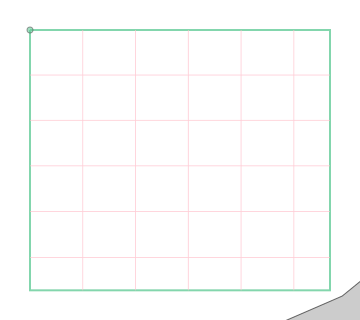

In [75]:
xx.odc.geobox

## Load data into local memory

In [19]:
%%time
xx = xx.compute()

/Users/dylan/opt/anaconda3/envs/odc-stac/lib/python3.10/site-packages/rasterio/warp.py:346: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


CPU times: user 5.14 s, sys: 974 ms, total: 6.11 s
Wall time: 29.2 s


## Load with bounding box

As you can see `stac_load` returned all the data covered by STAC items
returned from the query. This happens by default as `stac_load` has no way of
knowing what your query was. But it is possible to control what region is
loaded. There are several mechanisms available, but probably simplest one is
to use `bbox=` parameter (compatible with `stac_client`).

Let's load a small region at native resolution to demonstrate.

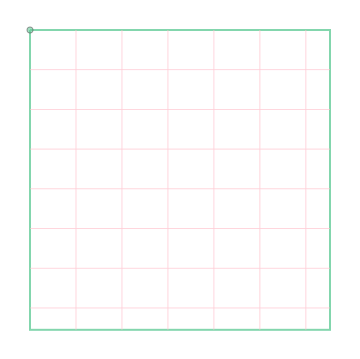

In [20]:
r = 6.5 * km2deg
small_bbox = (x - r, y - r, x + r, y + r)

yy = stac_load(
    items,
    crs=crs,
    resolution=10,
    chunks={},
    groupby="solar_day",
    stac_cfg=cfg,
    bbox=small_bbox,
)
display(yy.odc.geobox)

In [21]:
yy = yy.compute()

In [25]:
yy

<xarray.Dataset>
Dimensions:      (y: 1510, x: 1305, time: 1)
Coordinates:
  * y            (y) float64 3.545e+06 3.545e+06 3.545e+06 ... 3.53e+06 3.53e+06
  * x            (x) float64 -1.089e+07 -1.089e+07 ... -1.087e+07 -1.087e+07
    spatial_ref  int32 3857
  * time         (time) datetime64[ns] 2022-07-20T17:15:21
Data variables: (12/16)
    visual       (time, y, x) uint8 49 61 55 55 81 106 ... 175 175 149 143 138
    B01          (time, y, x) uint16 480 492 492 492 492 ... 762 762 762 762 754
    B02          (time, y, x) uint16 432 427 423 423 604 ... 1007 863 814 769
    B03          (time, y, x) uint16 716 741 697 697 796 ... 1344 1192 1122 1068
    B04          (time, y, x) uint16 504 593 536 536 806 ... 1732 1480 1394 1362
    B05          (time, y, x) uint16 1287 1237 1237 1237 ... 2187 2036 2036 1768
    ...           ...
    B09          (time, y, x) uint16 3041 3334 3334 3334 ... 3204 3204 3204 3057
    B11          (time, y, x) uint16 2219 2291 2291 2291 ... 4101 4093 4093 3921
    B12          (time, y, x) uint16 1198 1233 1233 1233 ... 2672 2732 2732 2674
    AOT          (time, y, x) uint16 110 110 110 110 110 ... 105 105 105 105 105
    WVP          (time, y, x) uint16 3308 3318 3318 3318 ... 3260 3082 3082 2976
    SCL          (time, y, x) uint8 4 4 4 4 4 4 4 4 4 4 ... 5 5 5 5 5 5 5 5 5 5

In [57]:
def skim(indata):
    variables = list(indata.data_vars)
    d = dict(indata.dtypes)
    types = [d[v] for v in list(indata.data_vars)]
    null_counts = indata.isnull().sum().to_array().data > 0
    mus = indata.mean().to_array().data
    stds = indata.std().to_array().data
    maxs = indata.max().to_array().data
    mins = indata.min().to_array().data
    CRS = indata.spatial_ref.data
    resolution = indata.x[1]-indata.x[0]

    data_dict = {
        "variables": variables,
        "data_types": types,
        "NaNs": null_counts,
        "mean": mus,
        "std": stds,
        "maximums":maxs,
        "minimums":mins,
    }
    df = pd.DataFrame(data_dict)
    df["resolution"] = 10
    df["CRS"] = CRS
    return df

In [58]:
df = skim(yy)
df

,variables,data_types,NaNs,mean,std,maximums,minimums,resolution,CRS
0,visual,uint8,False,139.425867,67.148813,255,12,10,3857
1,B01,uint16,False,1014.656807,485.679573,5556,246,10,3857
2,B02,uint16,False,1094.553693,754.101547,17896,1,10,3857
3,B03,uint16,False,1389.839233,784.223824,16920,232,10,3857
4,B04,uint16,False,1472.990419,936.560621,15768,131,10,3857
5,B05,uint16,False,1961.309226,835.362033,14081,59,10,3857
6,B06,uint16,False,2764.637920,693.970987,15817,26,10,3857
7,B07,uint16,False,3044.284501,728.957981,15711,7,10,3857
8,B08,uint16,False,3009.677979,787.918519,15656,85,10,3857
9,B8A,uint16,False,3272.293303,762.856630,15566,30,10,3857


In [68]:
## Aerosol Optical Thickness, Water Vapour, Scene Classification

<xarray.Dataset>
Dimensions:      (y: 1510, x: 1305, time: 1)
Coordinates:
  * y            (y) float64 3.545e+06 3.545e+06 3.545e+06 ... 3.53e+06 3.53e+06
  * x            (x) float64 -1.089e+07 -1.089e+07 ... -1.087e+07 -1.087e+07
    spatial_ref  int32 3857
  * time         (time) datetime64[ns] 2022-07-20T17:15:21
Data variables: (12/16)
    visual       (time, y, x) uint8 49 61 55 55 81 106 ... 175 175 149 143 138
    B01          (time, y, x) uint16 480 492 492 492 492 ... 762 762 762 762 754
    B02          (time, y, x) uint16 432 427 423 423 604 ... 1007 863 814 769
    B03          (time, y, x) uint16 716 741 697 697 796 ... 1344 1192 1122 1068
    B04          (time, y, x) uint16 504 593 536 536 806 ... 1732 1480 1394 1362
    B05          (time, y, x) uint16 1287 1237 1237 1237 ... 2187 2036 2036 1768
    ...           ...
    B09          (time, y, x) uint16 3041 3334 3334 3334 ... 3204 3204 3204 3057
    B11          (time, y, x) uint16 2219 2291 2291 2291 ... 4101 4093 4093 3921
    B12          (time, y, x) uint16 1198 1233 1233 1233 ... 2672 2732 2732 2674
    AOT          (time, y, x) uint16 110 110 110 110 110 ... 105 105 105 105 105
    WVP          (time, y, x) uint16 3308 3318 3318 3318 ... 3260 3082 3082 2976
    SCL          (time, y, x) uint8 4 4 4 4 4 4 4 4 4 4 ... 5 5 5 5 5 5 5 5 5 5